In [217]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn import preprocessing
import time
from datetime import datetime
from tqdm.auto import trange, tqdm
import os
import math
import datetime as dt
from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM, GRU, SimpleRNN, BatchNormalization
from keras.models import Sequential, load_model, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
from keras.optimizers import SGD,Adam
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import backend as K
from keras.losses import MeanSquaredLogarithmicError
from keras import Input

In [218]:
def plotTrainFigure(model, x_train, y_train, x_val, y_val, dates, trainDates, valDates, sc2, time_step=6, country='China', daily=False):
    if daily:
        title = 'New'
    else:
        title = 'Cumulative'
    #--------------------------------------------------Train---------------------------------------------------------#
    # Confirmed cases
    pre_train_confirmed = []
    truth_train_confirmed = []
    # Fatalities
    pre_train_fatalities = []
    truth_train_fatalities = []

    for i in range(len(x_train)):
        testx = np.array([x_train[i]])
        testy = np.array([y_train[i]])
        #         testx, testy  = train_generator[i]

        pre = model.predict(testx)

        confirmed_pre = pre[0][0]
        confirmed_truth = testy[0][0]
        fatalities_pre = pre[0][1]
        fatalities_truth = testy[0][1]

        t1, t3 = tuple(sc2.inverse_transform([[confirmed_pre, fatalities_pre]])[0])
        t2, t4 = tuple(sc2.inverse_transform([[confirmed_truth, fatalities_truth]])[0])
        pre_train_confirmed.append(t1)
        truth_train_confirmed.append(t2)
        pre_train_fatalities.append(t3)
        truth_train_fatalities.append(t4)
#     trainDates = dataframe[time_step:time_step + len(x_train)].index.values
    
    #--------------------------------------------------Validation---------------------------------------------------------#
    # Confirmed cases
    pre_val_confirmed = []
    truth_val_confirmed = []
    # Fatalities
    pre_val_fatalities = []
    truth_val_fatalities = []

    for i in range(len(x_val)):
        testx = np.array([x_val[i]])
        testy = np.array([y_val[i]])

        pre = model.predict(testx)

        confirmed_pre = pre[0][0]
        confirmed_truth = testy[0][0]
        fatalities_pre = pre[0][1]
        fatalities_truth = testy[0][1]

        t1, t3 = tuple(sc2.inverse_transform([[confirmed_pre, fatalities_pre]])[0])
        t2, t4 = tuple(sc2.inverse_transform([[confirmed_truth, fatalities_truth]])[0])
        pre_val_confirmed.append(t1)
        truth_val_confirmed.append(t2)
        pre_val_fatalities.append(t3)
        truth_val_fatalities.append(t4)
#     valDates = dataframe[time_step + len(x_train):].index.values
    
#     dates = dataframe.index.values
    #--------------------------------------------------Plot---------------------------------------------------------#
    dates  = date_remove_year(dates)
    trainDates  = date_remove_year(trainDates)
    valDates  = date_remove_year(valDates)
#     dates = dateStrs_to_dateframe(dates)
#     trainDates  = dateStrs_to_dateframe(trainDates)
#     valDates  = dateStrs_to_dateframe(valDates)
    
    print(len(trainDates), len(pre_train_confirmed), len(truth_train_confirmed))
    print(len(valDates), len(pre_val_confirmed), len(truth_val_confirmed))
    
    Confirmed = pd.DataFrame({'Date': trainDates, 'Prediction': pre_train_confirmed, 'Real cases': truth_train_confirmed})
    Confirmed.set_index(['Date'], inplace=True)

    Fatalities = pd.DataFrame({'Date': trainDates, 'Prediction': pre_train_fatalities, 'Real cases': truth_train_fatalities})
    Fatalities.set_index(['Date'], inplace=True)

    Confirmed['Prediction'] = Confirmed['Prediction'].astype(int)
    Confirmed['Real cases'] = Confirmed['Real cases'].astype(int)
    Fatalities['Prediction'] = Fatalities['Prediction'].astype(int)
    Fatalities['Real cases'] = Fatalities['Real cases'].astype(int)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(50, 10))
#     Confirmed.plot(ax=ax1)
    ax1.plot(trainDates, pre_train_confirmed, 'o--', color='violet')
    ax1.plot(trainDates, truth_train_confirmed, 'o--', color='coral')
    ax1.plot(valDates, pre_val_confirmed, 'o--', color='blue')  
    ax1.plot(valDates, truth_val_confirmed, 'o--', color='green')
    ax1.legend(['Predicted cases in train and val set', 'Real cases in train and val set', 
                'Predicted cases in test set', 'Real cases in test set'], loc='upper left')
    ax1.set_xticklabels(dates, rotation=45)
#     ax1.set_xticks(range(0,len(dates), 5))
#     ax1.set_xticklabels([dates[i] for i in range(len(dates)) if i % 5==0])  
# or
#     ax1.xaxis.set_major_locator(mdates.DayLocator(interval=6))
#     ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
#     
    ax1.set_title(country + " " + title+ " confirmed cases ", size=13)
    ax1.set_ylabel("Number of cases", size=13)
    ax1.set_xlabel("Date", size=13)

#     Fatalities.plot(ax=ax2)
    ax2.plot(trainDates, pre_train_fatalities, 'o--', color='violet')
    ax2.plot(trainDates, truth_train_fatalities, 'o--', color='coral')
    ax2.plot(valDates, pre_val_fatalities, 'o--', color='blue')  
    ax2.plot(valDates, truth_val_fatalities, 'o--', color='green')
    ax2.legend(['Predicted fatalities in train and val set', 'Real fatalities in train and val set', 
                'Predicted fatalities in test set', 'Real fatalities in test set'], loc='upper left')
    ax2.set_xticklabels(dates, rotation=45)

    ax2.set_title(country + " " + title+  " Fatalities ", size=13)
    ax2.set_ylabel("Number of cases", size=13)
    ax2.set_xlabel("Date", size=13)
    fig.savefig(country+title+'Result.png')
    return Confirmed.copy(), Fatalities.copy()

In [219]:
# Confirmed_train, Fatalities_train = plotTrainFigure(model, X_trainAndVal, Y_trainAndVal, X_test, Y_test, 
#                                                     dates, trainAndValDates, testDates, scb, time_step=time_step, country=country)

In [220]:
def datelist(beginDate, endDate):
    # beginDate, endDate are something like ‘20160601’
    date_l=[datetime.strftime(x,'%Y-%m-%d') for x in list(pd.date_range(start=beginDate, end=endDate))]
    return date_l

In [221]:
def date_remove_year(dates):
    return [datetime.strftime(datetime.strptime(x, '%Y-%m-%d'),'%m-%d') for x in dates]

In [222]:
def dateStrs_to_dateframe(dates):
    return [datetime.strptime(x, '%Y-%m-%d') for x in dates]

In [223]:
def printFigure(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss over epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

In [224]:
def MaxMinNormalization(data, feature_range=(0,1), split=0.8):
    sc = MinMaxScaler(feature_range=feature_range)
    scaled_data = sc.fit_transform(data.reshape(-1, 1)) if len(data.shape)==1 else sc.fit_transform(data)
#     scaled_data = data
    scaled_train = scaled_data[:int(len(scaled_data) * split)]
    scaled_val = scaled_data[int(len(scaled_data) * split):]
    return scaled_train, scaled_val, sc

In [225]:
def MaxMinNormalization2(data):
    sc = MinMaxScaler(feature_range=(0,1))
    scaled_data = sc.fit_transform(data.reshape(-1, 1)) if len(data.shape)==1 else sc.fit_transform(data)
    return scaled_data, sc

## Import data

In [226]:
rootPath = 'D:/Dropbox/Project/code/Python/COVID19-Global-Forecasting/data/'
trainFileName = 'train.csv'
testFileName = 'test.csv'
trainWithFlightFileName = 'train_flight.csv'
enrichedDataFileName = 'enriched_covid_19_week_2.csv'

### Load file

In [227]:
def loadDataByCountry(Country = 'China', data_all=None, dateRange= ('2020-01-22','2020-04-13'), is_startFromFirstCaseDay=False, daily=False):
    confirmed_total_date = data_all[data_all['Country_Region']==Country].groupby(['Date']).agg({'ConfirmedCases':['sum']})
    flight_total_date = data_all[data_all['Country_Region']==Country].groupby(['Date']).agg({'DepartureFlight':['mean']})
    data = data_all[data_all['Country_Region']==Country].groupby(['Date']).agg({'ConfirmedCases':['sum'],
                                                                                'Fatalities':['sum'],
                                                                                'DepartureFlight':['mean'],
                                                                                'hospibed':['mean'],
                                                                                'lung':['mean'],
                                                                                'total_pop':['mean'],
                                                                                'density':['mean'],
                                                                                'age_100+':['mean']})
    day = flight_total_date.shape[0]
#     for i in tqdm(range(day), desc='Complete zero-value in flight data'):
#         if flight_total_date.iloc[i].values[0]==0:
#             flight_total_date.iloc[i] = int((flight_total_date.iloc[i-1]+flight_total_date.iloc[i+1])/2)
    
    is_FirstCase = False
    FirstCaseDate = dateRange[0]
    for i in tqdm(range(day), desc='Complete zero-value in data'):
        Date = data.iloc[i].name
        if not is_FirstCase:
            if data.iloc[i].values[1]!=0:
                print('For ', country, 'The first case during the period just has been found', Date)
                FirstCaseDate = Date
                is_FirstCase = True
            
        if data.iloc[i].values[2]==0:
            data.loc[Date,'DepartureFlight'] = int((data.iloc[i-1]['DepartureFlight']+data.iloc[i+1]['DepartureFlight'])/2)
    
    if daily:
        data_ConfirmedCases = data.ConfirmedCases.diff()
        data_Fatalities = data.Fatalities.diff()
        
        if not is_startFromFirstCaseDay:
            data.ConfirmedCases = data_ConfirmedCases
            data.Fatalities = data_Fatalities
            return data.iloc[1:].loc[dateRange[0]: dateRange[1]]
        else:
            data.ConfirmedCases = data_ConfirmedCases
            data.Fatalities = data_Fatalities
            return data.iloc[1:].loc[FirstCaseDate: dateRange[1]]
    
    if not is_startFromFirstCaseDay:   
        return data.loc[dateRange[0]: dateRange[1]]
    else:
        return data.loc[FirstCaseDate: dateRange[1]]


In [228]:
# dateRange= ('2020-01-22','2020-04-13')
# data.iloc[1:].loc[dateRange[0]: dateRange[1]]
# loadDataByCountry(Country = country, data_all=rich_data, is_startFromFirstCaseDay=True, daily=True)

In [229]:
# data.ConfirmedCases.diff()

In [230]:
def load_extra_data(extra_data_df=None):
    extra_data_df["Country_Region"] = [country_name.replace("'","") if country_name.find('_')<0 else country_name[:country_name.find('_')].replace("'","") for country_name in extra_data_df["Country_Region"]]

#     extra_data_df["restrictions"] = extra_data_df["restrictions"].astype("int")
#     extra_data_df["quarantine"] = extra_data_df["quarantine"].astype("int")
#     extra_data_df["schools"] = extra_data_df["schools"].astype("int")
    extra_data_df["total_pop"] = extra_data_df["total_pop"].astype("float")
    extra_data_df["density"] = extra_data_df["density"].astype("float")
    extra_data_df["hospibed"] = extra_data_df["hospibed"].astype("float")
    extra_data_df["lung"] = extra_data_df["lung"].astype("float")
    extra_data_df["age_100+"] = extra_data_df["age_100+"].astype("float")
    
    extra_data_df["total_pop"] = extra_data_df["total_pop"]/max(extra_data_df["total_pop"])
    extra_data_df["density"] = extra_data_df["density"]/max(extra_data_df["density"])
    extra_data_df["hospibed"] = extra_data_df["hospibed"]/max(extra_data_df["hospibed"])
    extra_data_df["lung"] = extra_data_df["lung"]/max(extra_data_df["lung"])
    extra_data_df["age_100+"] = extra_data_df["age_100+"]/max(extra_data_df["age_100+"])

    extra_data_df = extra_data_df[["Country_Region","Date","hospibed","lung","total_pop","density","age_100+"]]
    return extra_data_df

In [231]:
def merge_extra_data(extra_data_df=None, raw_data=None):
    extra_data = load_extra_data(extra_data_df=extra_data_df)
    raw_data["Country_Region"] = [country_name.replace("'","") for country_name in raw_data["Country_Region"]]
    train_df = raw_data.merge(extra_data, how="left", on=['Country_Region','Date']).drop_duplicates()
    
    for country_region in train_df.Country_Region.unique():
        query_df = train_df.query("Country_Region=='"+country_region+"' and Date=='2020-03-25'")
        train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"total_pop"] = query_df.total_pop.values[0]
        train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"hospibed"] = query_df.hospibed.values[0]
        train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"density"] = query_df.density.values[0]
        train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"lung"] = query_df.lung.values[0]
        train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"age_100+"] = query_df["age_100+"].values[0]
    return train_df

## LSTM model

In [232]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(K.log(y_pred) - K.log(y_true)), axis=-1)) 

In [233]:
def aLSTM(time_step = 6, nfeatures=3):
    inputs = Input(shape=(time_step,nfeatures))
    lstm1 = LSTM(128, return_sequences = True, recurrent_dropout=0.5)(inputs)
    
    # Confiromed cases
    lstmC = LSTM(64)(lstm1)
    denseC1 = Dense(32, activation='relu')(lstmC)
    dropC1 = Dropout(0.5)(denseC1)
    denseC2 = Dense(2, activation='relu')(dropC1)
    
    # Fatalities
#     lstmF = LSTM(32)(lstm1)
#     denseF1 = Dense(128)(lstmF)
#     dropF1 = Dropout(0.5)(denseF1)
#     denseF2 = Dense(1, activation='relu')(dropF1)
    
    model = Model(inputs=inputs, outputs=denseC2)
#     
    model.compile(loss=MeanSquaredLogarithmicError(), optimizer='adam', metrics = ['accuracy'])
    model.summary()
    return model
    

## Training 

In [234]:
data_test = pd.read_csv(rootPath+testFileName)
data_all = pd.read_csv(rootPath+trainWithFlightFileName)
data_all.Province_State.fillna("None", inplace=True)
# data_all = data_all.drop(['Province_State'], axis=1)
extra_data_df = pd.read_csv(rootPath+enrichedDataFileName)
rich_data = merge_extra_data(extra_data_df=extra_data_df, raw_data=data_all)
dayList =datelist ('20200122','20200413')

In [242]:
split = 0.6
save_dir = "saved_models"
save_fname = os.path.join(save_dir, 'COVID19_LSTM.h5')
time_step = 6
country = 'US'
daily=False
data = loadDataByCountry(Country = country, data_all=rich_data, is_startFromFirstCaseDay=True, daily=daily)

# Only consider confiromed cases
data_single = data.values[:,0]

# Consider confiromed cases and Fatalities
data_CandF = data.values[:,0:2]
# Consider all features
data_multi_features = data.values

scaled_train1, scaled_val1, sc1 = MaxMinNormalization(data = data, split=0.8)
scaled_train2, scaled_val2, sc2 = MaxMinNormalization(data = data_CandF, split=0.8)
scaled_train3, scaled_val3, sc3 = MaxMinNormalization(data = data_multi_features, split=0.8)

scaled_data_a, sca = MaxMinNormalization2(data = data)
scaled_data_b,scb = MaxMinNormalization2(data = data_CandF)
scaled_data_c, scc = MaxMinNormalization2(data = data_multi_features)

For  US The first case during the period just has been found 2020-03-10



In [236]:
# print(rich_data[rich_data['Country_Region']=='China'].groupby(['Date']).agg({'Fatalities':['sum']}).loc['2020-02-22'])
# print(rich_data[rich_data['Country_Region']=='China'].groupby(['Date']).agg({'Fatalities':['sum']}).loc['2020-02-23'])

In [243]:
train_generator = TimeseriesGenerator(scaled_train3,scaled_train2, length = time_step, batch_size=1)
validation_gen = TimeseriesGenerator(scaled_val3,scaled_val2, length=time_step, batch_size=1)

In [244]:
data_gen = TimeseriesGenerator(scaled_data_c,scaled_data_b, length = time_step, batch_size=1)
# X_train = []
# Y_train = []
# X_val = []
# Y_val = []
X_data = []
Y_data = []
# Split train validation
num_train = int(split*len(data_gen))
num_test = num_val = int((1-split)/2*len(data_gen))

for i in range(len(data_gen)):
    X,Y= data_gen[i]
    X_data.append(X[0])
    Y_data.append(Y[0])
#     if i<= num_train:
#         X_train.append(X[0])
#         Y_train.append(Y[0])
#     else:
#         X_val.append(X[0])
#         Y_val.append(Y[0])
        
X_data = np.array(X_data)
Y_data = np.array(Y_data)
# X_train = np.array(X_train)
# Y_train = np.array(Y_train)
# X_val = np.array(X_val)
# Y_val = np.array(Y_val)

# Indiex
indices = np.array(range(X_data.shape[0]))
testI = indices[-num_test:]
trainAndValI = np.setdiff1d(indices,testI)
trainI = np.random.choice(X_data[trainAndValI].shape[0],size=num_train,replace=False)
valI = np.setdiff1d(trainAndValI,trainI)
# Data
X_train = X_data[trainI]
Y_train = Y_data[trainI]
X_val = X_data[valI]
Y_val = Y_data[valI]
X_test = X_data[testI]
Y_test = Y_data[testI]
# Date
dates = data[time_step:].index.values
trainDates = dates[trainI]
valDates = dates[valI]
testDates = dates[testI]
trainAndValDates = dates[trainAndValI]
#
knownI = np.argsort(trainAndValDates)
trainAndValDates = trainAndValDates[knownI]
X_trainAndVal = X_data[knownI]
Y_trainAndVal = Y_data[knownI]

In [245]:
epochs = 250
batch_size = 8
save_fname = os.path.join(save_dir, 'COVID19_LSTM.h5')

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 6, 8)              0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 6, 128)            70144     
_________________________________________________________________
lstm_32 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_31 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 2)                 66        
Total params: 121,698
Trainable params: 121,698
Non-trainable params: 0
____________________________________________________

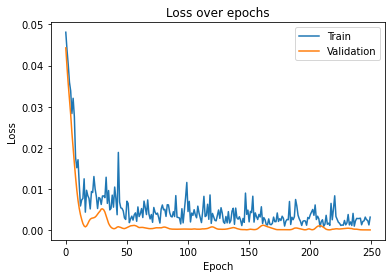

24 24 24
5 5 5


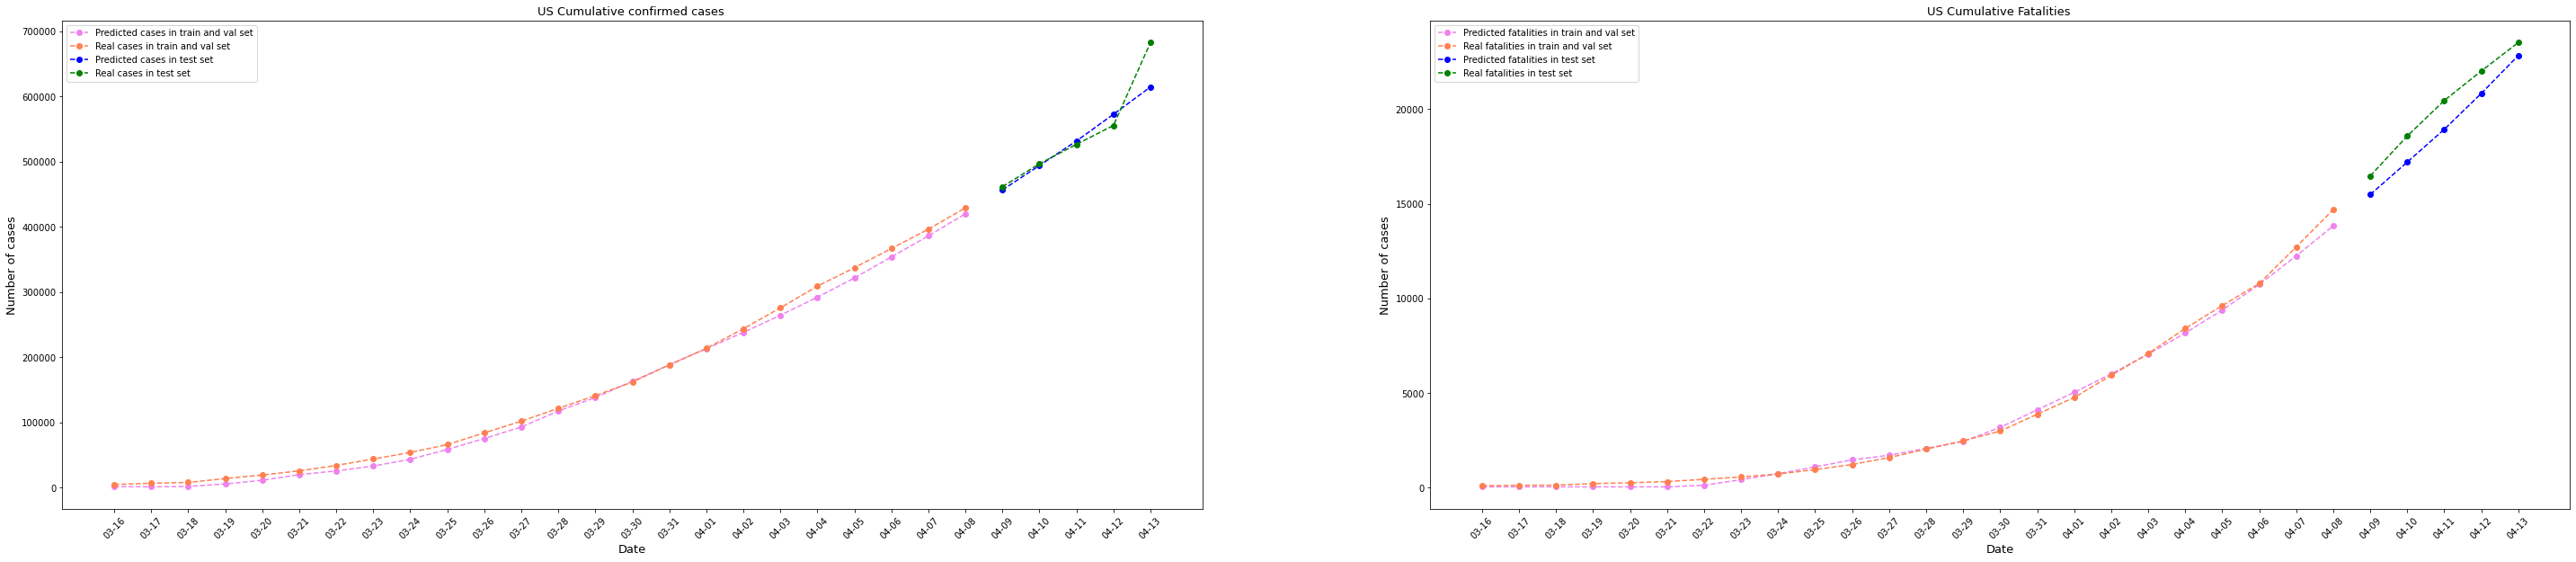

In [246]:
nfeatures = data.shape[1]
model = aLSTM(time_step, nfeatures=nfeatures)
print('[Model] Training Started')
print('[Model] %s epochs, %s batch size' % (epochs, batch_size))

# model.load_weights(save_fname)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=50),
    ModelCheckpoint(filepath=save_fname, monitor='val_loss', save_best_only=True),
#     TensorBoard(log_dir='./logs')
]
history = model.fit(x=X_train,y=Y_train, 
                    validation_data=(X_val,Y_val),
                    validation_steps=1,
                    callbacks=callbacks,steps_per_epoch=1,epochs=epochs,verbose=1)
model.save(save_fname)
print('[Model] Training Completed. Model saved as %s' % save_fname)
printFigure(history)
# Performance in train data
Confirmed_train, Fatalities_train = plotTrainFigure(model, X_trainAndVal, Y_trainAndVal, X_test, Y_test, 
                                                    dates, trainAndValDates, testDates, scb, time_step=time_step, country=country,daily=daily)